# (Start) Testing Area

In [ ]:
import torch

In [ ]:
x = torch.rand(8,5).cuda()

In [ ]:
x

In [ ]:
x.shape
# target shape [8, 7] where the extra size is a speaker_id embedding for local/global conditioning

In [ ]:
y = torch.ones(2)
print(y)
y=y.unsqueeze(0)
print(y)

In [ ]:
y = y.expand(x.shape[0],2)
print(y.shape)
print(x.shape)

In [ ]:
z = torch.cat([x,y], dim=1)
print(z)
print(z.shape)

In [ ]:
y.shape

In [ ]:
y[None, None, ...].shape

In [ ]:

#             [B, mels, T//n_group]
x = torch.rand(6, 160, 24000//8)
y = torch.ones(6, 40)
print(y.shape)
print(x.shape)

In [ ]:
%%timeit
z = torch.cat([x,(y.unsqueeze(-1).repeat(1, 1, x.shape[2]))], dim=1)

In [ ]:
x = torch.tensor(5)
print(x)
x.item()

In [ ]:
n_flows = 8
n_group = 8
perms = []
half = n_group // 2
for i in range(n_flows):
    perm = list(range(n_group))
    if i < n_flows // 2:
        perm = perm[::-1]
    else:
        perm[:half] = reversed(perm[:half])
        perm[half:] = reversed(perm[half:])
    perms.append(perm)
print("\n".join([str(perm) for perm in perms]))

# (End) Testing Area

# ----------------------------------

## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [7]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from unidecode import unidecode
import librosa

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [8]:
def plot_data(data, info=None):
    %matplotlib inline
    fig, axes = plt.subplots(len(data), 1, figsize=(int(alignment_graph_width*graph_scale/100), int(alignment_graph_height*graph_scale/100)))
    axes = axes.flatten()
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='inferno')
    axes[0].set(xlabel="Frames", ylabel="Channels")
    axes[1].set(xlabel="Decoder timestep", ylabel="Encoder timestep")
    fig.canvas.draw()
    plt.show()

#dictionary_path = r"/media/cookie/Samsung PM961/TwiBot/tacotron2/filelists/merged.dict_.txt"
dictionary_path = r"G:\TwiBot\tacotron2\filelists\merged.dict_.txt"
print("Running, Please wait...")
thisdict = {}
for line in reversed((open(dictionary_path, "r").read()).splitlines()):
    thisdict[(line.split(" ", 1))[0]] = (line.split(" ", 1))[1].strip()
print("Dictionary Ready.")
sym = list("☺☻♥♦♣♠•◘○◙♂♀♪♫☼►◄↕‼¶§▬↨↑↓→←∟↔▲▼")
def ARPA(text_, punc=r"!?,.;:␤#-_'\"()[]"):
    text = text_.replace("\n"," "); out = ''
    for word_ in text.split(" "):
        word=word_; end_chars = ''; start_chars = ''
        while any(elem in word for elem in punc) and len(word) > 1:
            if word[-1] in punc: end_chars = word[-1] + end_chars; word = word[:-1]
            elif word[0] in punc: start_chars = start_chars + word[0]; word = word[1:]
            else: break
        try: word_arpa = thisdict[word.upper()]
        except: word_arpa = ''
        if len(word_arpa)!=0: word = "{" + str(word_arpa) + "}"
        out = (out + " " + start_chars + word + end_chars).strip()
    #if out[-1] != "␤": out = out + "␤"
    #if out[0] != "☺": out = "☺" + out
    return out

Running, Please wait...
Dictionary Ready.


#### Setup hparams

In [9]:
hparams = create_hparams()
hparams.max_decoder_steps = 1000
hparams.gate_threshold = 0.6
hparams.ignore_layers = []
print(str(hparams))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

epochs=1000,iters_per_checkpoint=1000,iters_per_validation=1000,seed=1234,dynamic_loss_scaling=True,fp16_run=False,distributed_run=False,dist_backend=nccl,dist_url=tcp://127.0.0.1:54321,cudnn_enabled=True,cudnn_benchmark=False,ignore_layers=[],load_mel_from_disk=True,training_files=/media/cookie/Samsung 860 QVO/ClipperDatasetV2/filelists/mel_train_taca2_merged.txt,validation_files=/media/cookie/Samsung 860 QVO/ClipperDatasetV2/filelists/mel_validation_taca2_merged.txt,text_cleaners=['basic_cleaners'],max_wav_value=32768.0,sampling_rate=48000,filter_length=2400,hop_length=600,win_length=2400,n_mel_channels=160,mel_fmin=0.0,mel_fm

In [10]:
# allows WaveGlow from Ground Truth
from utils import load_wav_to_torch
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)
def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec

#### Load Tacotron2 model from checkpoint

In [11]:
checkpoint_path = r"G:\TwiBot\tacotron2-PPP-1.3.0\outdir_truncated1\checkpoint_58000"
print("Loading Tacotron... ", end="")
checkpoint_hparams = torch.load(checkpoint_path)['hparams']
#checkpoint_hparams.parse_json(hparams.to_json())
model = load_model(hparams)
checkpoint_dict = {k.replace("encoder_speaker_embedding.weight","encoder.encoder_speaker_embedding.weight"): v for k,v in torch.load(checkpoint_path)['state_dict'].items()}
model.load_state_dict(checkpoint_dict)
_ = model.cuda().eval().half(); print("Done")
print("This Tacotron model has been trained for ",torch.load(checkpoint_path)['iteration']," Iterations.")

Loading Tacotron... Done
This Tacotron model has been trained for  58000  Iterations.


In [12]:
print(model)

Tacotron2(
  (embedding): Embedding(179, 512)
  (encoder): Encoder(
    (encoder_speaker_embedding): Embedding(512, 256)
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(768, 384, batch_first=True, bidirectional=True)
    (LReLU): LeakyReLU(negative_slope=0.01)
  )
  (decoder): D

#### Load WaveGlow from Checkpoint

In [13]:
import torch
import json

# Load config file
config_fpath = r"H:\TTCheckpoints\waveglow\outdir_EfficientSmallGlobalSpeakerEmbeddings\Testing2\config.json"
with open(config_fpath) as f:
    data = f.read()
config = json.loads(data)
train_config = config["train_config"]
global data_config
data_config = config["data_config"]
global dist_config
dist_config = config["dist_config"]
global waveglow_config
waveglow_config = {
    **config["waveglow_config"], 
    'win_length': data_config['win_length'],
    'hop_length': data_config['hop_length']
}
print(waveglow_config)
print(f"Config File from '{config_fpath}' successfully loaded.")

# import the correct model
if waveglow_config["yoyo"]: # efficient_mode # TODO: Add to Config File
    from efficient_model import WaveGlow
else:
    from glow import WaveGlow

# initialize model
print(f"intializing WaveGlow model... ", end="")
waveglow = WaveGlow(**waveglow_config).cuda()
print(f"Done!")

#waveglow_path = '../tacotron2/waveglow_latest/outdir_twilight9/waveglow_341332'
waveglow_path = r"H:\TTCheckpoints\waveglow\outdir_EfficientSmallGlobalSpeakerEmbeddings\Testing2\best_val_model"
print(f"loading WaveGlow checkpoint... ", end="")
checkpoint = torch.load(waveglow_path)
waveglow.load_state_dict(checkpoint['model'])
waveglow.cuda().eval().half()
print(f"Done!")
#for k in waveglow.convinv:
#    k.float()
print(f"initializing Denoiser... ", end="")
denoiser = Denoiser(waveglow)
print(f"Done!")
waveglow_iters = torch.load(waveglow_path)['iteration']
print(waveglow_iters, "iterations")

{'yoyo': True, 'yoyo_WN': False, 'n_mel_channels': 160, 'n_flows': 16, 'n_group': 120, 'n_early_every': 16, 'n_early_size': 2, 'memory_efficient': False, 'spect_scaling': False, 'upsample_mode': 'normal', 'WN_config': {'n_layers': 5, 'n_channels': 384, 'kernel_size': 3, 'speaker_embed_dim': 96, 'rezero': False}, 'win_length': 2400, 'hop_length': 600}
Config File from 'H:\TTCheckpoints\waveglow\outdir_EfficientSmallGlobalSpeakerEmbeddings\Testing2\config.json' successfully loaded.
intializing WaveGlow model... Done!
loading WaveGlow checkpoint... Done!
initializing Denoiser... 

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Done!
278000 iterations


#### (Option 1) Get Speaker ID's from checkpoint

In [14]:
speaker_ids = checkpoint['speaker_lookup']
print(str(speaker_ids))

{0: 0, 1: 1, 10: 2, 100: 3, 101: 4, 102: 5, 103: 6, 104: 7, 105: 8, 106: 9, 107: 10, 108: 11, 109: 12, 11: 13, 110: 14, 111: 15, 112: 16, 113: 17, 114: 18, 115: 19, 116: 20, 117: 21, 118: 22, 119: 23, 12: 24, 120: 25, 121: 26, 122: 27, 123: 28, 124: 29, 125: 30, 126: 31, 127: 32, 128: 33, 129: 34, 13: 35, 130: 36, 131: 37, 132: 38, 133: 39, 134: 40, 135: 41, 136: 42, 137: 43, 138: 44, 139: 45, 14: 46, 140: 47, 141: 48, 142: 49, 143: 50, 144: 51, 145: 52, 146: 53, 147: 54, 148: 55, 149: 56, 15: 57, 150: 58, 151: 59, 152: 60, 153: 61, 154: 62, 155: 63, 156: 64, 157: 65, 158: 66, 159: 67, 16: 68, 160: 69, 161: 70, 162: 71, 163: 72, 164: 73, 165: 74, 166: 75, 167: 76, 168: 77, 169: 78, 17: 79, 170: 80, 171: 81, 172: 82, 173: 83, 174: 84, 175: 85, 176: 86, 177: 87, 178: 88, 179: 89, 18: 90, 180: 91, 181: 92, 182: 93, 183: 94, 184: 95, 185: 96, 186: 97, 187: 98, 188: 99, 189: 100, 19: 101, 190: 102, 191: 103, 192: 104, 193: 105, 194: 106, 195: 107, 196: 108, 197: 109, 198: 110, 199: 111, 2: 

#### (Option 2) Rebuild Speaker ID's from training filelist

In [15]:
#from data_utils import TextMelLoader
#from difflib import get_close_matches

In [16]:
#speaker_ids = TextMelLoader("/media/cookie/Samsung 860 QVO/ClipperDatasetV2/filelists/mel_train_taca2.txt", hparams).speaker_ids
#speaker_ids = TextMelLoader(r"D:\ClipperDatasetV2/filelists/mel_train_taca2.txt", hparams, check_files=False, TBPTT=False).speaker_ids
#print(str(speaker_ids).replace(", ","\n"))

#### Load TorchMoji for Style Tokens

In [17]:
# -*- coding: utf-8 -*-

""" Use torchMoji to score texts for emoji distribution.

The resulting emoji ids (0-63) correspond to the mapping
in emoji_overview.png file at the root of the torchMoji repo.

Writes the result to a csv file.
"""
import json
import numpy as np
import os

from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_feature_encoding
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
with open(VOCAB_PATH, 'r') as f:
    vocabulary = json.load(f)

maxlen = 180
texts = ["Testing!",]

with torch.no_grad():
    st = SentenceTokenizer(vocabulary, maxlen, ignore_sentences_with_only_custom=True)
    torchmoji = torchmoji_feature_encoding(PRETRAINED_PATH)
    tokenized, _, _ = st.tokenize_sentences(texts) # input array [B] e.g: ["Test?","2nd Sentence!"]
    embedding = torchmoji(tokenized) # returns np array [B, Embed]
    print(embedding)

Tokenizing using dictionary from G:\TwiBot\tacotron2-PPP-1.3.0/torchmoji/model/vocabulary.json
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights for output_layer.0.weight
Ignoring weights for output_layer.0.bias
[[ 0.00398057  0.01723153 -0.01075205 ... -0.01

Define a measure for Alignment quality in inferred clips.

In [18]:
def get_mask_from_lengths(lengths, max_len=None):
    if not max_len:
        max_len = torch.max(lengths).long()
    ids = torch.arange(0, max_len, device=lengths.device, dtype=torch.int64)
    mask = (ids < lengths.unsqueeze(1))
    return mask

# New MUCH more performant version, (doesn't support unique padded inputs, just iterate over the batch dim or smthn if you need padded inputs cause this is still way faster)
# @torch.jit.script # should work and be even faster, but makes it harder to debug and it's already fast enough right now
def alignment_metric(alignments, input_lengths=None, output_lengths=None, average_across_batch=False):
    alignments = alignments.transpose(1,2) # [B, dec, enc] -> [B, enc, dec]
    # alignments [batch size, x, y]
    # input_lengths [batch size] for len_x
    # output_lengths [batch size] for len_y
    if input_lengths == None:
        input_lengths =  torch.ones(alignments.size(0), device=alignments.device)*(alignments.shape[1]-1) # [B] # 147
    if output_lengths == None:
        output_lengths = torch.ones(alignments.size(0), device=alignments.device)*(alignments.shape[2]-1) # [B] # 767
    batch_size = alignments.size(0)
    optimums = torch.sqrt(input_lengths.double()**2 + output_lengths.double()**2).view(batch_size)
    
    # [B, enc, dec] -> [B, dec], [B, dec]
    values, cur_idxs = torch.max(alignments, 1) # get max value in column and location of max value
    
    cur_idxs = cur_idxs.float()
    prev_indx = torch.cat((cur_idxs[:,0][:,None], cur_idxs[:,:-1]), dim=1) # shift entire tensor right by one.
    dist = ((prev_indx - cur_idxs).pow(2) + 1).pow(0.5)
    dist.masked_fill_(~get_mask_from_lengths(output_lengths, max_len=dist.size(1)), 0.0)
    dist = dist.sum(dim=(1)) # remove padding
    diagonalitys = (dist + 1.4142135)/optimums # test soon please, this should work and make everything super fast
    
    alignments.masked_fill_(~get_mask_from_lengths(output_lengths, max_len=alignments.size(2))[:,None,:], 0.0)
    encoder_average_max_focus = torch.sum(alignments, dim=2).max(dim=1)[0] # [B, enc, dec] -> [B, sum_enc] -> [B]
    encoder_average_min_focus = torch.sum(alignments, dim=2).min(dim=1)[0]
    
    values.masked_fill_(~get_mask_from_lengths(output_lengths, max_len=values.size(1)), 0.0) # because padding
    avg_prob = values.mean(dim=1)
    avg_prob *= (alignments.size(2)/output_lengths.float()) # because padding
    
    if average_across_batch:
        diagonalitys = diagonalitys.mean()
        encoder_average_max_focus = encoder_average_max_focus.mean()
        encoder_average_min_focus = encoder_average_min_focus.mean()
        avg_prob = avg_prob.mean()
    return diagonalitys.cpu(), avg_prob.cpu(), encoder_average_max_focus.cpu(), encoder_average_min_focus.cpu()

#### Synthesize audio (From Filelist)

 Show,  My Little Pony, Trixie
raw_text:  A group of pony radicals try to summon a demon to overthrow the princesses. Instead they got a human. They don't know what a human is. That's it, the entire story in one fell swoop. Thanks for reading and all that.
model_input:  {AH0} {G R UW1 P} {AH1 V} {P OW1 N IY2} {R AE1 D AH0 K AH0 L Z} {T R AY1} {T IH0} {S AH1 M AH0 N} {AH0} {D IY1 M AH0 N} {T IH0} {OW1 V ER0 TH R OW2} {DH AH1} {P R IH1 N S EH0 S IH0 Z}. {IH0 N S T EH1 D} {DH EY1} {G AA1 T} {AH0} {Y UW1 M AH0 N}. {DH EY1} {D OW1 N} {N OW1} {W AH1 T} {AH0} {Y UW1 M AH0 N} {IH0 Z}. {DH AE1 T S} {IH1 T}, {DH AH1} {IH0 N T AY1 ER0} {S T AO1 R IY0} {IH0 N} {HH W AH1 N} {F EH1 L} {S W UW1 P}. {TH AE1 NG K S} {F ER0} {R EH1 D IH0 NG} {AE1 N D} {AO1 L} {DH AE1 T}.
-------------------------------------------------
1.095  66.46%  0.6035  0.06 0|1.251  61.23%  -0.1033  0.03 0.61|1.924  66.06%  0.2538  0.0 0|1.414  65.28%  0.4671  0.03 0|1.195  65.14%  -0.0606  0.0 0.67|1.064  66.55%  0.6639  0.0 0|2

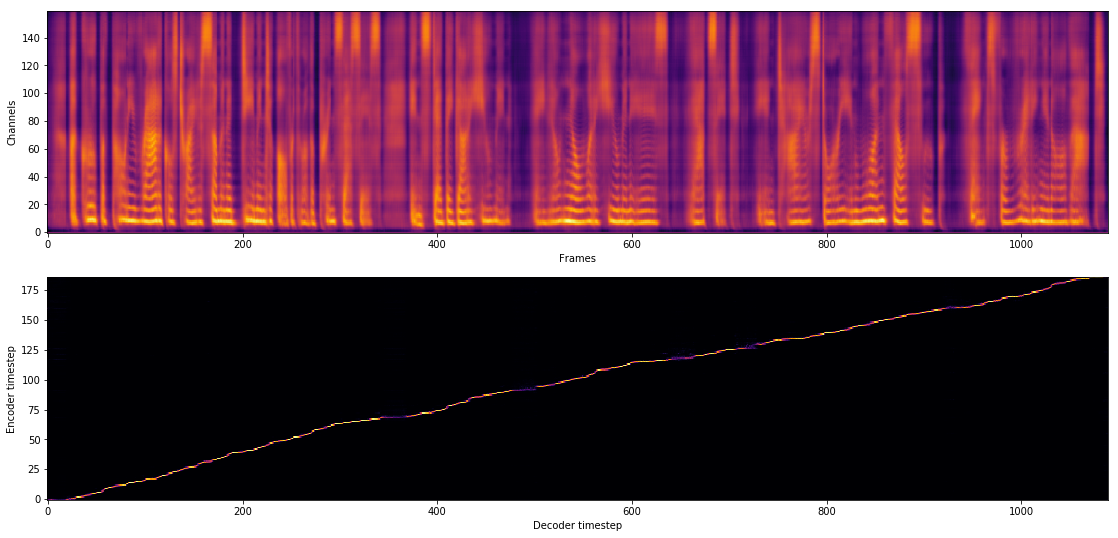

 Show,  My Little Pony, Chrysalis
raw_text:  A group of pony radicals try to summon a demon to overthrow the princesses. Instead they got a human. They don't know what a human is. That's it, the entire story in one fell swoop. Thanks for reading and all that.
model_input:  {AH0} {G R UW1 P} {AH1 V} {P OW1 N IY2} {R AE1 D AH0 K AH0 L Z} {T R AY1} {T IH0} {S AH1 M AH0 N} {AH0} {D IY1 M AH0 N} {T IH0} {OW1 V ER0 TH R OW2} {DH AH1} {P R IH1 N S EH0 S IH0 Z}. {IH0 N S T EH1 D} {DH EY1} {G AA1 T} {AH0} {Y UW1 M AH0 N}. {DH EY1} {D OW1 N} {N OW1} {W AH1 T} {AH0} {Y UW1 M AH0 N} {IH0 Z}. {DH AE1 T S} {IH1 T}, {DH AH1} {IH0 N T AY1 ER0} {S T AO1 R IY0} {IH0 N} {HH W AH1 N} {F EH1 L} {S W UW1 P}. {TH AE1 NG K S} {F ER0} {R EH1 D IH0 NG} {AE1 N D} {AO1 L} {DH AE1 T}.
-------------------------------------------------


KeyboardInterrupt: 

In [19]:
#text = "They say the eyes are the window to the soul, and you can clearly see the desire burning within them for the treasure you now hold. It's honestly a little frightening. never before have you seen Celestia's perfect composure slip like this, and you find yourself having to push her muzzle away from your face before she starts drooling on you.;"
"""
|Derpy|29
|Spitfire|57
|Twilight|3
|Applejack|4
|Rarity|2
|RD|1
|Pinkie Pie|0
|Fluttershy|11
|Spike|10
|Trixie|13
|Celestia|14
|Luna|17
|Cadance|19
|Shining Armor|22
"""

clips = """
|(Show) My Little Pony_Trixie|84
|(Show) My Little Pony_Chrysalis|86
|(Audiodrama) Fallout Equestria_Littlepip|194
|(Show) My Little Pony_Twilight|32
|(Show) My Little Pony_Applejack|24
|(Show) My Little Pony_Rainbow|25
|(Show) My Little Pony_Pinkie|26
|(Show) My Little Pony_Rarity|27
|(Show) My Little Pony_Spike|28
|(Show) My Little Pony_Fluttershy|29
|(Game) Them's Fightin' Herds_Oleander|15
|(Game) Them's Fightin' Herds_Fred|16
|(Game) Them's Fightin' Herds_Pom|17
|(Game) Them's Fightin' Herds_Velvet|18
|(Game) Them's Fightin' Herds_Arizona|19
|(Game) Them's Fightin' Herds_Tianhuo|20
|(Show) My Little Pony_Nightmare Moon|30
|(Show) Dan Vs_Dan|31
|(Show) My Little Pony_Grubber|33
|(Show) My Little Pony_Scootaloo|34
|(Show) My Little Pony_Sweetie Belle|35
|(Show) My Little Pony_Apple Bloom|36
|(Show) My Little Pony_Big Mac|37
|(Show) My Little Pony_Discord|38
|(Show) My Little Pony_Mrs. Cake|39
|(Show) My Little Pony_Sugar Belle|40
|(Show) My Little Pony_Granny Smith|41
|(Show) My Little Pony_Mayor Mare|42
|(Show) My Little Pony_Derpy|43
|(Show) My Little Pony_Cherry Jubilee|44
|(Show) My Little Pony_Sky Stinger|45
|(Show) My Little Pony_Vapor Trail|46
|(Show) My Little Pony_Spitfire|47
|(Show) My Little Pony_Misty Fly|48
|(Show) My Little Pony_Stellar Flare|49
|(Show) My Little Pony_Sunburst|50
|(Show) My Little Pony_Starlight|51
|(Show) My Little Pony_Firelight|52
|(Show) My Little Pony_Jack Pot|53
|(Show) My Little Pony_Soarin|54
|(Show) My Little Pony_Goldie Delicious|55
|(Show) My Little Pony_Apple Rose|56
|(Show) My Little Pony_Auntie Applesauce|57
|(Show) My Little Pony_Big Bucks|58
|(Show) My Little Pony_Celestia|59
|(Show) My Little Pony_Raspberry Beret|60
|(Show) My Little Pony_On Stage|61
|(Show) My Little Pony_Sunset Shimmer|62
|(Show) My Little Pony_Vignette|63
|(Show) My Little Pony_Micro Chips|64
|(Show) My Little Pony_Sky Beak|65
|(Show) My Little Pony_Terramar|66
|(Show) My Little Pony_Ocean Flow|67
|(Show) My Little Pony_Smolder|68
|(Show) My Little Pony_Yona|69
|(Show) My Little Pony_Gallus|70
|(Show) My Little Pony_Ocellus|71
|(Show) My Little Pony_Sandbar|72
|(Show) My Little Pony_Silverstream|73
|(Show) My Little Pony_Zephyr|74
|(Show) My Little Pony_Snips|75
|(Show) My Little Pony_Luna|76
|(Show) My Little Pony_Flam|77
|(Show) My Little Pony_Flim|78
|(Show) My Little Pony_Photo Finish|79
|(Show) My Little Pony_Cranky|80
|(Show) My Little Pony_Zecora|81
|(Show) My Little Pony_Luster Dawn|82
|(Show) My Little Pony_Flash Sentry|83
|(Show) My Little Pony_Cadance|85
|(Show) My Little Pony_Tirek|87
|(Show) My Little Pony_Cozy Glow|88
|(Show) My Little Pony_Thorax|89
|(Show) My Little Pony_Spur|90
|(Show) My Little Pony_Biscuit|91
|(Show) My Little Pony_Octavia|92
|(Show) My Little Pony_Burnt Oak|93
|(Show) My Little Pony_Bright Mac|94
|(Show) My Little Pony_Pear Butter|95
|(Show) My Little Pony_Grand Pear|96
|(Show) My Little Pony_Rockhoof|97
|(Show) My Little Pony_Grogar|98
|(Show) My Little Pony_Star Swirl|99
|(Show) My Little Pony_Hoo'Far|100
|(Show) My Little Pony_Autumn Blaze|101
|(Show) My Little Pony_Trouble Shoes|102
|(Show) My Little Pony_Braeburn|103
|(Show) My Little Pony_Mean Applejack|104
|(Show) My Little Pony_Mean Pinkie Pie|105
|(Show) My Little Pony_Mean Twilight Sparkle|106
|(Show) My Little Pony_Photographer|107
|(Show) My Little Pony_Mean Fluttershy|108
|(Show) My Little Pony_Mean Rarity|109
|(Show) My Little Pony_Lyra|110
|(Show) My Little Pony_Sweetie Drops|111
|(Show) My Little Pony_Dr. Hooves|112
|(Show) My Little Pony_Matilda|113
|(Show) My Little Pony_Steve|114
|(Show) My Little Pony_Sludge|115
|(Show) My Little Pony_Maud|116
|(Show) My Little Pony_Meadowbrook|117
|(Show) My Little Pony_Neighsay|118
|(Show) My Little Pony_Ember|119
|(Show) My Little Pony_Mudbriar|120
|(Show) My Little Pony_Limestone|121
|(Show) My Little Pony_Lightning Dust|122
|(Show) My Little Pony_Diamond Tiara|123
|(Show) My Little Pony_Babs Seed|124
|(Show) My Little Pony_Silver Spoon|125
|(Show) My Little Pony_Shining Armor|126
|(Show) My Little Pony_Miss Harshwhinny|127
|(Show) My Little Pony_Saffron Masala|128
|(Show) My Little Pony_Coriander Cumin|129
|(Show) My Little Pony_Zesty Gourmand|130
|(Show) My Little Pony_Gladmane|131
|(Show) My Little Pony_Dragon Lord Torch|132
|(Show) My Little Pony_Bulk Biceps|133
|(Show) My Little Pony_Party Favor|134
|(Show) My Little Pony_Double Diamond|135
|(Show) My Little Pony_Filthy Rich|136
|(Show) My Little Pony_Gabby|137
|(Show) My Little Pony_Spoiled Rich|138
|(Show) My Little Pony_Quibble Pants|139
|(Show) My Little Pony_A. K. Yearling|140
|(Show) My Little Pony_Dr. Caballeron|141
|(Show) My Little Pony_Fleetfoot|142
|(Show) My Little Pony_Cheerilee|143
|(Show) My Little Pony_Mrs. Shy|144
|(Show) My Little Pony_Mane-Iac|145
|(Show) My Little Pony_Ahuizotl|146
|(Show) My Little Pony_Sapphire Shores|147
|(Show) My Little Pony_Cheese Sandwich|148
|(Show) My Little Pony_Pharynx|149
|(Show) My Little Pony_Hoity Toity|150
|(Show) My Little Pony_Iron Will|151
|(Show) My Little Pony_Sassy Saddles|152
|(Show) My Little Pony_Caballeron|153
|(Show) My Little Pony_Rumble|154
|(Show) My Little Pony_Thunderlane|155
|(Show) My Little Pony_Windy Whistles|156
|(Show) My Little Pony_Bow Hothoof|157
|(Show) My Little Pony_Prince Rutherford|158
|(Show) My Little Pony_Gilda|159
|(Show) My Little Pony_Twist|160
|(Show) My Little Pony_Moon Dancer|161
|(Show) My Little Pony_Garble|162
|(Show) My Little Pony_Mane Allgood|163
|(Show) My Little Pony_Snap Shutter|164
|(Show) My Little Pony_Fancy Pants|165
|(Show) My Little Pony_Wind Sprint|166
|(Show) My Little Pony_Clear Sky|167
|(Show) My Little Pony_Sans Smirk|168
|(Show) My Little Pony_Night Glider|169
|(Show) My Little Pony_Minuette|170
|(Show) My Little Pony_Lemon Hearts|171
|(Show) My Little Pony_Ma Hooffield|172
|(Show) My Little Pony_Big Daddy Mccolt|173
|(Show) My Little Pony_Igneous|174
|(Show) My Little Pony_Tree Hugger|175
|(Show) My Little Pony_Wind Rider|176
|(Show) My Little Pony_Pipsqueak|177
|(Show) My Little Pony_Coco Pommel|178
|(Show) My Little Pony_Countess Coloratura|179
|(Show) My Little Pony_Svengallop|180
|(Show) My Little Pony_Juniper Montage|181
|(Show) My Little Pony_Adagio Dazzle|182
|(Show) My Little Pony_Sonata Dusk|183
|(Show) My Little Pony_Aria Blaze|184
|(Show) My Little Pony_Wallflower|185
|(Show) My Little Pony_Sour Sweet|186
|(Show) My Little Pony_Sugarcoat|187
|(Show) My Little Pony_Canter Zoom|188
|(Show) My Little Pony_Chestnut Magnifico|189
|(Show) My Little Pony_Gloriosa Daisy|190
|(Show) My Little Pony_Timber Spruce|191
|(Show) My Little Pony_Cinch|192
|(Game) Sonic_Blaze|195
|Postal Dude|196
""".replace("_",", ").replace("("," ").replace(")",", ").split("\n")[1:-1]

_text_override = """A group of pony radicals try to summon a demon to overthrow the princesses. Instead they got a human. They don't know what a human is. That's it, the entire story in one fell swoop. Thanks for reading and all that."""
_audio_path_override = None
_speaker_id_override = None
style_mode = 'torchmoji_hidden' # Options = 'mel','token','zeros','torchmoji_hidden','torchmoji_string'

acceptable_alignment = 0.76 # threshold to stop retrying
acceptable_diagonality = 1.5 # maximum diagonality, 1.04 is average GT. 1.00 is a diagonal line.

# Score Parameters
diagonality_weighting = 0.5 # 'stutter factor', a penalty for clips where the model jumps back and forwards in the sentence.
max_focus_weighting = 1.0   # 'stuck factor', a penalty for clips that spend execisve time on the same letter.
min_focus_weighting = 1.0   # 'skip factor', a penalty for skipping/ignoring parts of the input text.
max_attempts = 256 # retries at each clip

max_decoder_steps = 2000
max_text_segment_length = 200
sigma = 1.0
gate_threshold = 0.5
gate_delay = 0
use_arpabet = 1
save_wavs = 1 # saves wavs to infer folder
show_audio = 1
show_graphs = 1
graph_scale = 0.5
alignment_graph_width = 3840
alignment_graph_height = 1920
batch_size = 256

model.decoder.gate_delay = gate_delay
model.decoder.max_decoder_steps = max_decoder_steps
model.decoder.gate_threshold = gate_threshold

counter = 0
for clip in clips:
    audio_path, text, speaker_id = clip.split("|")
    
    # one moment DEBUG
    #text = _text_override + " " + text.split(", ")[-1] +" and I will be your helper today."
    
    # use overrides as needed
    if _text_override != None:
        print(text) # DEBUG
        text = _text_override
    if _audio_path_override != None:
        audio_path = _audio_path_override
    if _speaker_id_override != None:
        speaker_id = _speaker_id_override
    
    # get speaker_id
    speaker_id = speaker_ids[int(speaker_id)]
    speaker_id = torch.LongTensor([speaker_id]).cuda().repeat(batch_size)
    
    # style
    if style_mode == 'mel':
        mel = load_mel(audio_path.replace(".npy",".wav")).cuda().half()
        style_input = mel
    elif style_mode == 'token':
        pass
        #style_input =
    elif style_mode == 'zeros':
        style_input = None
    elif style_mode == 'torchmoji_hidden':
        tokenized, _, _ = st.tokenize_sentences([text,]) # input array [B] e.g: ["Test?","2nd Sentence!"]
        embedding = torchmoji(tokenized) # returns np array [B, Embed]
        style_input = torch.from_numpy(embedding).cuda().half().repeat(batch_size,1)
    elif style_mode == 'torchmoji_string':
        style_input = [text,]
    else:
        raise NotImplementedError
    
    # add punc
    if text[-1] not in ',.?!;:': text+='.'
    
    # parse text
    text = text.replace("...",".")
    text = unidecode(text)
    print("raw_text: ",text)
    if use_arpabet: text = ARPA(text)
    else: text = f"☺{text}␤"
    print("model_input: ",text)
    
    print("-------------------------------------------------")
    with torch.no_grad():
        sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :] # convert text to tensor representation
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long().repeat(batch_size, 1)
        for i in range(1):
            # text, speaker_ids, style_mel=None, style_int=None, style_token=None, style_torchmoji_hidden=None, style_torchmoji_string=None
            avg_prob = torch.tensor(0.0)
            best_score=torch.tensor(-9e9)
            tries = 0
            try:
                while avg_prob.item() < acceptable_alignment or diagonality.item() > acceptable_diagonality:
                    # run inference
                    mel_batch_outputs, mel_batch_outputs_postnet, gate_batch_outputs, alignments_batch = model.inference(sequence, speaker_id, style_input=style_input, style_mode=style_mode)
                    
                    # find metrics for each item
                    gate_batch_outputs[:,:8] = 0 # ignore gate predictions for the first 0.05s
                    output_lengths = gate_batch_outputs.argmax(dim=1)
                    diagonality_batch, avg_prob_batch, enc_max_focus_batch, enc_min_focus_batch = alignment_metric(alignments_batch, output_lengths=output_lengths)
                    
                    batch = zip(
                        mel_batch_outputs.split(1,dim=0),
                        mel_batch_outputs_postnet.split(1,dim=0),
                        gate_batch_outputs.split(1,dim=0),
                        alignments_batch.split(1,dim=0),)
                    # split batch into items
                    
                    for j, (mel_outputs, mel_outputs_postnet, gate_outputs, alignments) in enumerate(batch):
                        diagonality = diagonality_batch[j]
                        avg_prob = avg_prob_batch[j]
                        enc_max_focus = enc_max_focus_batch[j]
                        enc_min_focus = enc_min_focus_batch[j]
                        weighted_score = avg_prob.item()-((max(diagonality.item(),1.11)-1.11) * diagonality_weighting + max((enc_max_focus.item()-20), 0) * 0.005 * max_focus_weighting)-(max(0.9-enc_min_focus.item(),0)*min_focus_weighting)
                        score_str = f"{round(diagonality.item(),3)}  {round(avg_prob.item()*100,2)}%  {round(weighted_score,4)}  {round(max((enc_max_focus.item()-20), 0) * 0.005 * max_focus_weighting,2)} {round(max(0.9-enc_min_focus.item(),0),2)}|"
                        if weighted_score > best_score:
                            best_score = weighted_score
                            best_score_str = score_str
                            best_generation = [mel_outputs, mel_outputs_postnet, gate_outputs, alignments]
                        print(score_str, end="")
                        tries+=1
                        if tries > (max_attempts-1): raise StopIteration
            except StopIteration:
                pass
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments = best_generation# pickup whatever was the best attempt
            
            # remove any padding
            mel_outputs = mel_outputs[:,:,:gate_outputs.argmax()]
            mel_outputs_postnet = mel_outputs_postnet[:,:,:gate_outputs.argmax()]
            alignments = alignments[:,:gate_outputs.argmax(),:]
            
            speaker_id = speaker_id[:mel_outputs_postnet.size(0)] # remove excess speaker_ids
            print(f"\nScore: {best_score}\nStats: {best_score_str}")
            
            plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                   alignments.float().data.cpu().numpy()[0].T))
            audio = waveglow.infer(mel_outputs_postnet, speaker_ids=speaker_id, sigma=sigma)
            audio_denoised = denoiser(audio, strength=0.0001)[:, 0]
            ipd.display(ipd.Audio(audio.cpu().numpy(), rate=hparams.sampling_rate))        
            if save_wavs:
                save_audio_path = f"infer/audio_{counter}.wav"
                if os.path.exists(save_audio_path):
                    os.remove(save_audio_path)
                librosa.output.write_wav(save_audio_path, np.swapaxes(audio.float().cpu().numpy(),0,1), hparams.sampling_rate)
            counter+=1
_text = None; _audio_path = None; _speaker_id = None

#### Synthesize audio (From Text List e.g Fimfic)

In [20]:
def parse_txt_into_quotes(fpath):
    texts = open(fpath, "r", encoding="utf-8").read()
    
    quo ='"'; texts = [f'"{text.replace(quo,"").strip()}"' if i%2 else text.replace(quo,"").strip() for i, text in enumerate(unidecode(texts).split('"'))]

    texts_segmented = []
    for text in texts:
        text = text.strip()
        if not len(text.replace('"','').strip()): continue
        text = text\
            .replace("\n"," ")\
            .replace("  "," ")\
            .replace("> --------------------------------------------------------------------------","")
        if len(text) > max_text_segment_length:
            for seg in [x.strip() for x in text.split(".") if len(x.strip()) if x is not '"']: 
                if '"' in text:
                    if seg[0] != '"': seg='"'+seg
                    if seg[-1] != '"': seg+='"'
                texts_segmented.append(seg)
        else:
            texts_segmented.append(text.strip())
    return texts_segmented

In [ ]:
from unidecode import unidecode
import random
from datetime import datetime
from time import sleep

"""
|(Show) My Little Pony_Trixie|84
|(Show) My Little Pony_Chrysalis|86
|(Audiodrama) Fallout Equestria_Littlepip|194
|(Show) My Little Pony_Twilight|32
|(Show) My Little Pony_Applejack|24
|(Show) My Little Pony_Rainbow|25
|(Show) My Little Pony_Pinkie|26
|(Show) My Little Pony_Rarity|27
|(Show) My Little Pony_Spike|28
|(Show) My Little Pony_Fluttershy|29
|(Game) Them's Fightin' Herds_Oleander|15
|(Game) Them's Fightin' Herds_Fred|16
|(Game) Them's Fightin' Herds_Pom|17
|(Game) Them's Fightin' Herds_Velvet|18
|(Game) Them's Fightin' Herds_Arizona|19
|(Game) Them's Fightin' Herds_Tianhuo|20
|(Show) My Little Pony_Nightmare Moon|30
|(Show) Dan Vs_Dan|31
|(Show) My Little Pony_Grubber|33
|(Show) My Little Pony_Scootaloo|34
|(Show) My Little Pony_Sweetie Belle|35
|(Show) My Little Pony_Apple Bloom|36
|(Show) My Little Pony_Big Mac|37
|(Show) My Little Pony_Discord|38
|(Show) My Little Pony_Mrs. Cake|39
|(Show) My Little Pony_Sugar Belle|40
|(Show) My Little Pony_Granny Smith|41
|(Show) My Little Pony_Mayor Mare|42
|(Show) My Little Pony_Derpy|43
|(Show) My Little Pony_Cherry Jubilee|44
|(Show) My Little Pony_Sky Stinger|45
|(Show) My Little Pony_Vapor Trail|46
|(Show) My Little Pony_Spitfire|47
|(Show) My Little Pony_Misty Fly|48
|(Show) My Little Pony_Stellar Flare|49
|(Show) My Little Pony_Sunburst|50
|(Show) My Little Pony_Starlight|51
|(Show) My Little Pony_Firelight|52
|(Show) My Little Pony_Jack Pot|53
|(Show) My Little Pony_Soarin|54
|(Show) My Little Pony_Goldie Delicious|55
|(Show) My Little Pony_Apple Rose|56
|(Show) My Little Pony_Auntie Applesauce|57
|(Show) My Little Pony_Big Bucks|58
|(Show) My Little Pony_Celestia|59
|(Show) My Little Pony_Raspberry Beret|60
|(Show) My Little Pony_On Stage|61
|(Show) My Little Pony_Sunset Shimmer|62
|(Show) My Little Pony_Vignette|63
|(Show) My Little Pony_Micro Chips|64
|(Show) My Little Pony_Sky Beak|65
|(Show) My Little Pony_Terramar|66
|(Show) My Little Pony_Ocean Flow|67
|(Show) My Little Pony_Smolder|68
|(Show) My Little Pony_Yona|69
|(Show) My Little Pony_Gallus|70
|(Show) My Little Pony_Ocellus|71
|(Show) My Little Pony_Sandbar|72
|(Show) My Little Pony_Silverstream|73
|(Show) My Little Pony_Zephyr|74
|(Show) My Little Pony_Snips|75
|(Show) My Little Pony_Luna|76
|(Show) My Little Pony_Flam|77
|(Show) My Little Pony_Flim|78
|(Show) My Little Pony_Photo Finish|79
|(Show) My Little Pony_Cranky|80
|(Show) My Little Pony_Zecora|81
|(Show) My Little Pony_Luster Dawn|82
|(Show) My Little Pony_Flash Sentry|83
|(Show) My Little Pony_Cadance|85
|(Show) My Little Pony_Tirek|87
|(Show) My Little Pony_Cozy Glow|88
|(Show) My Little Pony_Thorax|89
|(Show) My Little Pony_Spur|90
|(Show) My Little Pony_Biscuit|91
|(Show) My Little Pony_Octavia|92
|(Show) My Little Pony_Burnt Oak|93
|(Show) My Little Pony_Bright Mac|94
|(Show) My Little Pony_Pear Butter|95
|(Show) My Little Pony_Grand Pear|96
|(Show) My Little Pony_Rockhoof|97
|(Show) My Little Pony_Grogar|98
|(Show) My Little Pony_Star Swirl|99
|(Show) My Little Pony_Hoo'Far|100
|(Show) My Little Pony_Autumn Blaze|101
|(Show) My Little Pony_Trouble Shoes|102
|(Show) My Little Pony_Braeburn|103
|(Show) My Little Pony_Mean Applejack|104
|(Show) My Little Pony_Mean Pinkie Pie|105
|(Show) My Little Pony_Mean Twilight Sparkle|106
|(Show) My Little Pony_Photographer|107
|(Show) My Little Pony_Mean Fluttershy|108
|(Show) My Little Pony_Mean Rarity|109
|(Show) My Little Pony_Lyra|110
|(Show) My Little Pony_Sweetie Drops|111
|(Show) My Little Pony_Dr. Hooves|112
|(Show) My Little Pony_Matilda|113
|(Show) My Little Pony_Steve|114
|(Show) My Little Pony_Sludge|115
|(Show) My Little Pony_Maud|116
|(Show) My Little Pony_Meadowbrook|117
|(Show) My Little Pony_Neighsay|118
|(Show) My Little Pony_Ember|119
|(Show) My Little Pony_Mudbriar|120
|(Show) My Little Pony_Limestone|121
|(Show) My Little Pony_Lightning Dust|122
|(Show) My Little Pony_Diamond Tiara|123
|(Show) My Little Pony_Babs Seed|124
|(Show) My Little Pony_Silver Spoon|125
|(Show) My Little Pony_Shining Armor|126
|(Show) My Little Pony_Miss Harshwhinny|127
|(Show) My Little Pony_Saffron Masala|128
|(Show) My Little Pony_Coriander Cumin|129
|(Show) My Little Pony_Zesty Gourmand|130
|(Show) My Little Pony_Gladmane|131
|(Show) My Little Pony_Dragon Lord Torch|132
|(Show) My Little Pony_Bulk Biceps|133
|(Show) My Little Pony_Party Favor|134
|(Show) My Little Pony_Double Diamond|135
|(Show) My Little Pony_Filthy Rich|136
|(Show) My Little Pony_Gabby|137
|(Show) My Little Pony_Spoiled Rich|138
|(Show) My Little Pony_Quibble Pants|139
|(Show) My Little Pony_A. K. Yearling|140
|(Show) My Little Pony_Dr. Caballeron|141
|(Show) My Little Pony_Fleetfoot|142
|(Show) My Little Pony_Cheerilee|143
|(Show) My Little Pony_Mrs. Shy|144
|(Show) My Little Pony_Mane-Iac|145
|(Show) My Little Pony_Ahuizotl|146
|(Show) My Little Pony_Sapphire Shores|147
|(Show) My Little Pony_Cheese Sandwich|148
|(Show) My Little Pony_Pharynx|149
|(Show) My Little Pony_Hoity Toity|150
|(Show) My Little Pony_Iron Will|151
|(Show) My Little Pony_Sassy Saddles|152
|(Show) My Little Pony_Caballeron|153
|(Show) My Little Pony_Rumble|154
|(Show) My Little Pony_Thunderlane|155
|(Show) My Little Pony_Windy Whistles|156
|(Show) My Little Pony_Bow Hothoof|157
|(Show) My Little Pony_Prince Rutherford|158
|(Show) My Little Pony_Gilda|159
|(Show) My Little Pony_Twist|160
|(Show) My Little Pony_Moon Dancer|161
|(Show) My Little Pony_Garble|162
|(Show) My Little Pony_Mane Allgood|163
|(Show) My Little Pony_Snap Shutter|164
|(Show) My Little Pony_Fancy Pants|165
|(Show) My Little Pony_Wind Sprint|166
|(Show) My Little Pony_Clear Sky|167
|(Show) My Little Pony_Sans Smirk|168
|(Show) My Little Pony_Night Glider|169
|(Show) My Little Pony_Minuette|170
|(Show) My Little Pony_Lemon Hearts|171
|(Show) My Little Pony_Ma Hooffield|172
|(Show) My Little Pony_Big Daddy Mccolt|173
|(Show) My Little Pony_Igneous|174
|(Show) My Little Pony_Tree Hugger|175
|(Show) My Little Pony_Wind Rider|176
|(Show) My Little Pony_Pipsqueak|177
|(Show) My Little Pony_Coco Pommel|178
|(Show) My Little Pony_Countess Coloratura|179
|(Show) My Little Pony_Svengallop|180
|(Show) My Little Pony_Juniper Montage|181
|(Show) My Little Pony_Adagio Dazzle|182
|(Show) My Little Pony_Sonata Dusk|183
|(Show) My Little Pony_Aria Blaze|184
|(Show) My Little Pony_Wallflower|185
|(Show) My Little Pony_Sour Sweet|186
|(Show) My Little Pony_Sugarcoat|187
|(Show) My Little Pony_Canter Zoom|188
|(Show) My Little Pony_Chestnut Magnifico|189
|(Show) My Little Pony_Gloriosa Daisy|190
|(Show) My Little Pony_Timber Spruce|191
|(Show) My Little Pony_Cinch|192
|(Game) Sonic_Blaze|195
|Postal Dude|196
"""

speakers = """
|(Show) My Little Pony_Fluttershy|29
""".replace("_",", ").replace("("," ").replace(")",", ").split("\n")[1:-1]

narrators = """
|(Show) My Little Pony_Applejack|24
""".replace("_",", ").replace("("," ").replace(")",", ").split("\n")[1:-1]

_audio_path_override = None
_speaker_id_override = None
style_mode = 'torchmoji_hidden' # Options = 'mel','token','zeros','torchmoji_hidden','torchmoji_string'

acceptable_alignment = 0.76 # threshold to stop retrying
acceptable_diagonality = 1.5 # maximum diagonality, 1.04 is average GT. 1.00 is a diagonal line.

absolutely_required_score = 0.3 # retry forever until this score is reached

# Score Parameters
diagonality_weighting = 0.5 # 'stutter factor', a penalty for clips where the model jumps back and forwards in the sentence.
max_focus_weighting = 1.0   # 'stuck factor', a penalty for clips that spend execisve time on the same letter.
min_focus_weighting = 1.0   # 'skip factor', a penalty for skipping/ignoring parts of the input text.
max_attempts = 256 # retries at each clip
batch_size = 256

max_decoder_steps = 2000
max_text_segment_length = 200
gate_threshold = 0.5
gate_delay = 6
use_arpabet = 1

sigma = 1.0
audio_save_path = r"D:\Downloads\infer\audio"
save_wavs = 1 # saves wavs to infer folder

show_all_attempt_scores = 0
show_best_score = 1
show_audio = 0
show_graphs = 0
status_updates = 1 # ... Done
graph_scale = 0.5
alignment_graph_width = 3840
alignment_graph_height = 1920

model.decoder.gate_delay = gate_delay
model.decoder.max_decoder_steps = max_decoder_steps
model.decoder.gate_threshold = gate_threshold

file_path = r"D:\Downloads\infer\text\Mort Takes a Holiday.txt"

texts_segmented = parse_txt_into_quotes(file_path)

total_len = len(texts_segmented)

continue_from = 0 # skip
counter = 0
for text_index, text in enumerate(texts_segmented):
    if text_index < continue_from: print(f"Skipping {text_index}.\t\t",end=""); continue
    print(f"{text_index}/{total_len}|{datetime.now()}")
    if '"' in text: # quote
        audio_path, _, speaker_id = random.choice(speakers).split("|")
        text = text.replace('"',"")
    else: # non-quote/non-dialogue
        audio_path, _, speaker_id = random.choice(narrators).split("|")
    
    if _audio_path_override != None:
        audio_path = _audio_path_override
    if _speaker_id_override != None:
        speaker_id = _speaker_id_override
    
    # get speaker_id
    speaker_id = speaker_ids[int(speaker_id)]
    speaker_id = torch.LongTensor([speaker_id]).cuda().repeat(batch_size)
    
    # style
    if style_mode == 'mel':
        mel = load_mel(audio_path.replace(".npy",".wav")).cuda().half()
        style_input = mel
    elif style_mode == 'token':
        pass
        #style_input =
    elif style_mode == 'zeros':
        style_input = None
    elif style_mode == 'torchmoji_hidden':
        try:
            tokenized, _, _ = st.tokenize_sentences([text,]) # input array [B] e.g: ["Test?","2nd Sentence!"]
        except:
            raise Exception(f"text\n{text}\nfailed to tokenize.")
        try:
            embedding = torchmoji(tokenized) # returns np array [B, Embed]
        except Exception as ex:
            print(ex)
            print(f"text\n{text}\nfailed to process.")
            #raise Exception(f"text\n{text}\nfailed to process.")
        style_input = torch.from_numpy(embedding).cuda().half().repeat(batch_size,1)
    elif style_mode == 'torchmoji_string':
        style_input = [text,]
    else:
        raise NotImplementedError
    
    # add punc
    if text[-1] not in ',.?!;:': text+='.'
    
    # parse text
    text = text.replace("...",". ").replace("  "," ").strip()
    text = unidecode(text)
    print("raw_text: ",text)
    if use_arpabet: text = ARPA(text)
    else: text = f"☺{text}␤"
    print("model_input: ",text)
    
    print("-------------------------------------------------")
    with torch.no_grad():
        sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :] # convert text to tensor representation
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long().repeat(batch_size, 1)
        for i in range(1):
            # text, speaker_ids, style_mel=None, style_int=None, style_token=None, style_torchmoji_hidden=None, style_torchmoji_string=None
            avg_prob = torch.tensor(0.0)
            best_score=torch.tensor(-9e9)
            tries = 0
            try:
                while avg_prob.item() < acceptable_alignment or diagonality.item() > acceptable_diagonality:
                    # run inference
                    if status_updates: print("Running Tacotron2... ", end='')
                    mel_batch_outputs, mel_batch_outputs_postnet, gate_batch_outputs, alignments_batch = model.inference(sequence, speaker_id, style_input=style_input, style_mode=style_mode)
                    
                    # find metrics for each item
                    gate_batch_outputs[:,:8] = 0 # ignore gate predictions for the first 0.05s
                    output_lengths = gate_batch_outputs.argmax(dim=1)+gate_delay
                    diagonality_batch, avg_prob_batch, enc_max_focus_batch, enc_min_focus_batch = alignment_metric(alignments_batch, output_lengths=output_lengths)
                    
                    batch = zip(
                        mel_batch_outputs.split(1,dim=0),
                        mel_batch_outputs_postnet.split(1,dim=0),
                        gate_batch_outputs.split(1,dim=0),
                        alignments_batch.split(1,dim=0),)
                    # split batch into items
                    
                    for j, (mel_outputs, mel_outputs_postnet, gate_outputs, alignments) in enumerate(batch):
                        diagonality = diagonality_batch[j]
                        avg_prob = avg_prob_batch[j]
                        enc_max_focus = enc_max_focus_batch[j]
                        enc_min_focus = enc_min_focus_batch[j]
                        weighted_score = avg_prob.item()-((max(diagonality.item(),1.11)-1.11) * diagonality_weighting + max((enc_max_focus.item()-20), 0) * 0.005 * max_focus_weighting)-(max(0.9-enc_min_focus.item(),0)*min_focus_weighting)
                        score_str = f"{round(diagonality.item(),3)} {round(avg_prob.item()*100,2)}% {round(weighted_score,4)} {round(max((enc_max_focus.item()-20), 0) * 0.005 * max_focus_weighting,2)} {round(max(0.9-enc_min_focus.item(),0),2)}|"
                        if weighted_score > best_score:
                            best_score = weighted_score
                            best_score_str = score_str
                            best_generation = [mel_outputs, mel_outputs_postnet, gate_outputs, alignments]
                        if show_all_attempt_scores:
                            print(score_str, end="")
                        tries+=1
                        if tries > (max_attempts-1) and best_score > absolutely_required_score:
                            raise StopIteration
                        if tries>=1024:
                            print("Absolutely required score not achieved in 1024 attempts - ", end='')
                            raise StopIteration
                    if tries < (max_attempts-1):
                        print('Acceptable alignment/diagonality not reached. Retrying.')
                    elif best_score < absolutely_required_score:
                        print('Score less than absolutely required score. Retrying.')
            except StopIteration:
                if status_updates: print("Done")
                pass
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments = best_generation# pickup whatever was the best attempt
            
            # remove any padding
            mel_outputs = mel_outputs[:,:,:gate_outputs.argmax()+gate_delay]
            mel_outputs_postnet = mel_outputs_postnet[:,:,:gate_outputs.argmax()+gate_delay]
            alignments = alignments[:,:gate_outputs.argmax()+gate_delay,:]
            
            speaker_id = speaker_id[:mel_outputs_postnet.size(0)] # remove excess speaker_ids
            if show_best_score:
                print(f"Score: {best_score}\nStats: {best_score_str}  Verified: {[x.item() for x in alignment_metric(alignments)]}")
            if show_graphs:
                plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                       alignments.float().data.cpu().numpy()[0].T))
            if status_updates: print("Running WaveGlow... ", end='')
            audio = waveglow.infer(mel_outputs_postnet, speaker_ids=speaker_id, sigma=sigma)
            audio_denoised = denoiser(audio, strength=0.0001)[:, 0]
            if status_updates: print('Done')
            if show_audio:
                ipd.display(ipd.Audio(audio.cpu().numpy(), rate=hparams.sampling_rate))        
            if save_wavs:
                save_audio_path = os.path.join(audio_save_path,f"audio_{counter//300:02}_{counter:05}.wav")
                if os.path.exists(save_audio_path):
                    print(f"File already found at [{save_audio_path}], overwriting.")
                    os.remove(save_audio_path)
                if status_updates: print(f"Saving clip to [{save_audio_path}]... ", end="")
                librosa.output.write_wav(save_audio_path, np.swapaxes(audio.float().cpu().numpy(),0,1), hparams.sampling_rate)
                if status_updates: print("Done")
            
            print("")
            counter+=1
_text = None; _audio_path = None; _speaker_id = None

0/14063|2020-05-13 06:31:23.998401
raw_text:  > Mort Takes a Holiday > by AnonymousMaterials > Meet Mort From Terry Trotchett's A Concise History of Equestria:
model_input:  > {M AO1 R T} {T EY1 K S} {AH0} {HH AA1 L AH0 D EY2} > {B AY1} AnonymousMaterials > {M IY1 T} {M AO1 R T} {F R AH1 M} {T EH1 R IY0} Trotchett's {AH0} {K AH0 N S AY1 S} {HH IH1 S T R IY0} {AH1 V} {IH0 K W EH0 S T R IY0 AH0}:
-------------------------------------------------
Running Tacotron2... Warning! Reached max decoder steps
Done
Score: 0.5590625
Stats: 1.1 61.52% 0.5591 0.06 0|  Verified: [1.1002476118658087, 0.61572265625, 31.140625, 0.95849609375]
Running WaveGlow... Done
File already found at [D:\Downloads\infer\audio\audio_00_00000.wav], overwriting.
Saving clip to [D:\Downloads\infer\audio\audio_00_00000.wav]... Done

1/14063|2020-05-13 06:31:46.180218
raw_text:  If you were to ask some ponies what they thought of Equestria, there would typically be one of three responses.
model_input:  {IH0 F} {Y UW1} {W 

# Show saved Postnet Outputs

In [ ]:
from glob import glob
import random
import numpy as np
import matplotlib
import torch
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue"
#filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2"
files = sorted(glob(filepath+"/**/*.mel.npy", recursive=True))
start = int(random.random() * len(files))
file_count = 10
for i in range(start, start+file_count):
    #file = random.choice(files)
    file = files[i]
    H = np.load(file)
    H = (H+5.2)*0.5
    %matplotlib inline
    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(111)
    ax.set_title(file+"\n"+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='inferno', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()
    
    # again
    file = file.replace(".mel.npy",".npy")
    H = np.load(file)
    H = (H+5.2)*0.5
    %matplotlib inline
    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(111)
    ax.set_title(file+"\n"+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='inferno', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.show()

# Size of GT Spectrograms

In [ ]:
from glob import glob
import os
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

#filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue/FiM/S1/s1e1"
filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2"
files = sorted(glob(filepath+"/**/*.npy", recursive=True))
total_size = 0
min_duration = 0.6
SR = 48000
BD = 2 # 16 bits
for path in files:
    file_size = os.stat(path).st_size
    if file_size > (SR*BD*min_duration):
        total_size+=file_size

duration = total_size / (SR*BD)
duration_min = duration/60
duration_hrs = duration/3600
total_size_MB = total_size / (1024**3)
print(f"{total_size_MB} GB")

# Size & Duration of Wavs

In [ ]:
from glob import glob
import os
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd
def get_stats(filepath, ext='.wav'):
    import soundfile as sf
    files = sorted(glob(filepath+f"/**/*{ext}", recursive=True))
    total_size = 0
    total_duration = 0
    min_duration = 0.6
    SR = 48000
    BD = 2 # 16 bits
    for path in files:
        file_size = os.stat(path).st_size
        audio, samplerate = sf.read(path)
        if len(audio)/samplerate > min_duration:
            total_size+=file_size
            total_duration+=len(audio)/samplerate
    duration_min = total_duration/60
    duration_hrs = total_duration/3600
    print(f"{total_duration} seconds = {duration_min} minutes = {duration_hrs} hours")
    total_size_MB = total_size / (1024**3)
    print(f"{total_size_MB} GB of wavs")

get_stats(r"/media/cookie/Samsung 860 QVO/ClipperDatasetV2/Blizzard2011", ext='.wav')

In [ ]:
print(torch.cuda.current_device())
print(torch.cuda.device_count())

# Testing FP16 vs FP32 individual Tensor Operations

In [ ]:
import torch

tensor.inverse()

In [ ]:
%%timeit
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).cuda().half()
#########################################################
def b_inv(b_mat):
    eye = b_mat.new_ones(b_mat.size(-1)).diag().expand_as(b_mat).float()
    b_inv, _ = torch.solve(eye.float(), b_mat.float())
    return b_inv
fp16 = b_inv(weight.squeeze())
#########################################################
print(fp16)

In [ ]:
%%timeit
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).cuda().float()
#########################################################
fp32 = weight.squeeze().inverse()
#########################################################
print(fp32)
#assert torch.equal(fp32.float(), fp16.float())

tensor.slogdet()

In [ ]:
%%timeit
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).unsqueeze(0).repeat(1000,2,2).cuda().float()
#########################################################
log_det_W = weight.squeeze().slogdet()[1]

In [ ]:
%%timeit
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).unsqueeze(0).repeat(1000,2,2).cuda().float()
#########################################################
log_det_W = weight.squeeze().logdet()

In [ ]:
%%timeit
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).unsqueeze(0).repeat(1000,2,2).cuda().float()
#########################################################
log_det_W = weight.squeeze().det().log()

In [ ]:
%%timeit -n 10000
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).unsqueeze(0).repeat(500,1,1).cuda().half()
#########################################################
log_det_W = weight.squeeze().float().det().log().half()

In [ ]:
%%timeit -n 10000
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).unsqueeze(0).repeat(500,1,1).cuda().half()
#########################################################
log_det_W = weight.squeeze().float().det().half().log()

In [ ]:
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).cuda().half()
#########################################################
log_det_W = weight.squeeze().float().det().half().log()
print(log_det_W)

In [ ]:
weight = torch.tensor([[1,2,3],
                       [4,5,6],
                       [7,8,9]]).cuda()
weight.half()
weight.type()

# Evaluate Multiple WaveGlow Models

In [ ]:
import torch
from denoiser import Denoiser
from glob import glob
from random import random
import os
import numpy as np
import soundfile as sf
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
from layers import TacotronSTFT, STFT
from utils import load_wav_to_torch
from hparams import create_hparams
%matplotlib inline
def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec
def disp_mel(H, desc=''):
    %matplotlib inline
    fig = plt.figure(figsize=(6, 4))

    ax = fig.add_subplot(111)
    ax.set_title(desc+"\n"+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='inferno', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    #plt.colorbar(orientation='vertical')
    plt.show()
def plot_audio_spec(audio, sampling_rate=48000):
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec


def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec


def load_model(waveglow_path):
    from efficient_model import WaveGlow
    from efficient_util import remove_weight_norms
    import json
    data = r"""{
        "train_config": {
            "fp16_run": false,
            "output_directory": "outdir_EfficientBaseline",
            "epochs": 1000,
            "learning_rate": 1e-4,
            "sigma": 1.0,
            "iters_per_checkpoint": 2000,
            "batch_size": 30,
            "seed": 1234,
            "checkpoint_path": "outdir_EfficientBaseline/waveglow_1425",
            "with_tensorboard": true
        },
        "data_config": {
            "training_files": "map_0_GT.txt",
            "segment_length": 19200,
            "sampling_rate": 48000,
            "filter_length": 2400,
            "hop_length": 600,
            "win_length": 2400,
            "mel_fmin": 0.0,
            "mel_fmax": 16000.0
        },
        "dist_config": {
            "dist_backend": "nccl",
            "dist_url": "tcp://127.0.0.1:54321"
        },
        "waveglow_config": {
            "n_mel_channels": 160,
            "n_flows": 12,
            "n_group": 8,
            "n_early_every": 4,
            "n_early_size": 2,
            "memory_efficient": false,
            "WN_config": {
                "dilation_channels":256,
                "residual_channels":256,
                "skip_channels":256,
                "n_layers": 9,
                "radix": 3,
                "bias": true
            }
        }
    }"""
    config = json.loads(data)
    train_config = config["train_config"]
    global data_config
    data_config = config["data_config"]
    global dist_config
    dist_config = config["dist_config"]
    global waveglow_config
    waveglow_config = { 
        **config["waveglow_config"], 
        'win_length': data_config['win_length'],
        'hop_length': data_config['hop_length']
    }
    waveglow = WaveGlow(**waveglow_config).cuda()
    waveglow_dict = torch.load(waveglow_path)['model'].state_dict()
    waveglow.load_state_dict(waveglow_dict)
    waveglow.apply(remove_weight_norms)
    waveglow.cuda().eval()#.half()
    #for k in waveglow.convinv:
    #    k.float()
    #denoiser = Denoiser(waveglow)
    waveglow_iters = torch.load(waveglow_path)['iteration']
    print(waveglow_iters, "iterations")
    return waveglow, waveglow_iters


def waveglow_infer(mel_outputs_postnet, sigma_, iters=''):
    current_audio = waveglow.infer(mel_outputs_postnet, sigma=sigma_).unsqueeze(0)
    audio.append(current_audio)
    print("sigma = {}".format(sigma_)); ipd.display(ipd.Audio(audio[len(audio)-1][0].data.cpu().numpy(), rate=hparams.sampling_rate))
    maxv = np.iinfo(np.int16).max
    sf.write("infer/temp.wav", (np.swapaxes(audio[len(audio)-1].cpu().numpy(),0,1) * maxv).astype(np.int16), hparams.sampling_rate)
    disp_mel(load_mel("infer/temp.wav").squeeze(), desc=file_path+f"\nAfter WaveGlow {iters}\nSigma {sigma_}")


def waveglow_infer_filepath(file_path, sigma_, iters=''):
    mel_outputs_postnet = np.load(file_path)
    mel_outputs_postnet = (mel_outputs_postnet+5.2)*0.5 # shift values between approx -4 and 4
    mel_outputs_postnet = torch.from_numpy(mel_outputs_postnet).unsqueeze(0).cuda()#.half()
    audio = []
    with torch.no_grad():
        waveglow_infer(mel_outputs_postnet, sigma_, iters=iters)

audio = []
hparams = create_hparams()
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)
filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue"
files = sorted(glob(filepath+"/**/*.npy", recursive=True))

In [ ]:
file_path = files[int(random()*len(files))]
print(file_path)

In [ ]:
"""outdir_EfficientBaseline/waveglow_5158
outdir_EfficientBaseline/waveglow_5483
outdir_EfficientBaseline/waveglow_5666
outdir_EfficientBaseline/waveglow_7264
outdir_EfficientBias/waveglow_252
outdir_EfficientBias/waveglow_655
outdir_EfficientBias/waveglow_1003
outdir_EfficientBias/waveglow_1935
outdir_EfficientBias/waveglow_11346
outdir_EfficientBias/waveglow_11863
outdir_EfficientBias/waveglow_12118
outdir_EfficientBias/waveglow_12282
outdir_EfficientBias/waveglow_14197
outdir_EfficientBias/waveglow_16058"""
model_paths = r"""
outdir_EfficientBias/waveglow_365
""".split("\n")

disp_mel(load_mel(file_path.replace(".mel.npy",".wav").replace(".npy",".wav")).squeeze(), desc=file_path.replace(".mel.npy",".wav").replace(".npy",".wav")+f"\nGround Truth")
for model_path in [path for path in model_paths if path]:
    waveglow, iters = load_model(f"/media/cookie/Samsung 860 QVO/TTCheckpoints/waveglow/{model_path}")
    waveglow_infer_filepath(file_path, 0.9, iters=iters)

# WaveGlow GTA Inference

In [ ]:
import torch
import torch.nn as nn
from denoiser import Denoiser
from glob import glob
from random import random
import os
import numpy as np
import soundfile as sf
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
from layers import TacotronSTFT, STFT
from utils import load_wav_to_torch
from hparams import create_hparams
from shutil import copyfile

from waveglow_utils import PreEmphasis, InversePreEmphasis
%matplotlib inline
def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec
def disp_mel(H, desc=''):
    %matplotlib inline
    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(111)
    ax.set_title(desc+"\nLength: "+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='inferno', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    #plt.colorbar(orientation='vertical')
    plt.show()
def plot_audio_spec(audio, sampling_rate=48000):
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec
def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec
hparams = create_hparams()
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)
#stft_wideband = TacotronSTFT(hparams.filter_length, hparams.hop_length, 1024,
#                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
#                    hparams.mel_fmax)

Nvidia WaveGlow

In [ ]:
def load_waveglow(waveglow_path):
    waveglow_dict = torch.load(waveglow_path)
    waveglow = waveglow_dict['model']
    waveglow_iters = int(waveglow_dict['iteration'])
    waveglow.cuda().eval().half()
    denoiser = Denoiser(waveglow)
    print(waveglow_iters, "iterations")
    if not hasattr(waveglow, "spect_scaling"):
        setattr(waveglow, "spect_scaling", False)
    return waveglow, denoiser, waveglow_iters

def load_waveglow_yoyo(waveglow_path):
    waveglow_dict = torch.load(waveglow_path)
    waveglow = waveglow_dict['model']
    waveglow_iters = int(waveglow_dict['iteration'])
    waveglow.cuda().eval()#.half()
    denoiser = None#Denoiser(waveglow)
    print(waveglow_iters, "iterations")
    return waveglow, denoiser, waveglow_iters

In [ ]:
waveglow_dict = torch.load("/media/cookie/Samsung 860 QVO/TTCheckpoints/waveglow/outdir_EfficientLarge/best_model")
waveglow = waveglow_dict['model']
waveglow_iters = int(waveglow_dict['iteration'])
waveglow.cuda().eval()#.half()
denoiser = None#Denoiser(waveglow)
print(waveglow_iters, "iterations")
print(waveglow.WNs)

In [ ]:
print(waveglow.WNs[0].WN)

Select Random File

In [ ]:
def waveglow_infer(mel_outputs_postnet, sigma_, deempathsis, root_dir='infer', clip_folder='', filename=''):
    current_audio = waveglow.infer(mel_outputs_postnet, sigma=sigma_)
    if len(current_audio.shape) == 1:
        current_audio = current_audio.unsqueeze(0)
    if deempathsis:
        deempthasis_filter = InversePreEmphasis(float(deempathsis)) # TODO, replace with something lightweight.
        current_audio = deempthasis_filter(current_audio.cpu().float().unsqueeze(0)).squeeze(0).cuda()
    audio.append(current_audio)
    
    # Show Audio for Listening in Notebook
    #ipd.display(ipd.Audio(audio[len(audio)-1][0].data.cpu().numpy(), rate=hparams.sampling_rate))
    
    # Save Audio
    local_fpath = os.path.join(root_dir, clip_folder, filename) # local filepath
    local_dpath = os.path.join(root_dir, clip_folder) # local directory path
    os.makedirs(local_dpath, exist_ok=True) # ensure local directory exists
    maxv = np.iinfo(np.int16).max # get max int16 value
    sf.write(os.path.join(root_dir, "temp.wav"), (np.swapaxes(audio[len(audio)-1].cpu().numpy(),0,1) * maxv).astype(np.int16), hparams.sampling_rate) # write audio to temp
    
    # Get MSE and MAE
    waveglow_spect = load_mel(os.path.join(root_dir, "temp.wav")).squeeze() # load spectrogram from wav file.
    waveglow_spect_lossy = (waveglow_spect.unsqueeze(0).cuda().half()[:,:,:mel_outputs_postnet.shape[-1]])#+5.2)*0.5 # move spectrogram to GPU, reshape and normalize within -4, 4.
    MSE = (nn.MSELoss()(waveglow_spect_lossy, mel_outputs_postnet)).item() # get MSE (Mean Squared Error) between Ground Truth and WaveGlow inferred spectrograms.
    MAE = (nn.L1Loss()(waveglow_spect_lossy, mel_outputs_postnet)).item() # get MAE (Mean Absolute Error) between Ground Truth and WaveGlow inferred spectrograms.
    
    #sf.write(local_fpath+f"-MSE_{round(MSE,4)}.wav", (np.swapaxes(audio[len(audio)-1].cpu().numpy(),0,1) * maxv).astype(np.int16), hparams.sampling_rate) # write audio to fpath
    sf.write(local_fpath+f"-MSE_{round(MSE,4)}.wav", np.swapaxes(audio[len(audio)-1].cpu().numpy(),0,1), hparams.sampling_rate, "PCM_16") # write audio to fpath
    # Show Spect
    #disp_mel(waveglow_spect, desc=f"\nAfter WaveGlow\nSigma: {sigma_}\nMSELoss: {MSE}") # Show Plot in Notebook
    return MSE, MAE

In [ ]:
filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue"
files = sorted(glob(filepath+"/**/*__*.npy", recursive=True))

In [ ]:
waveglow_infer_paths = [
    "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue/Special source/s6e24/00_04_52_Rainbow_Neutral__That's a mighty big claim considering everypony here is an amazingly awesome crazy good flyer.mel.npy"
]
for i in range(19):
    file_path = files[int(random()*len(files))]
    waveglow_infer_paths.append(file_path)
print("".join([x+"\n" for x in waveglow_infer_paths]))# Print each entry in multiple lines.

In [ ]:
x="""
# Baseline, 12 Flow, 256 Channel, 8 Layer, 0.00 Empthasis
outdir_twilight9/waveglow_140900|1|0|0.00|0
outdir_twilight9/waveglow_152256|1|0|0.00|0
outdir_twilight9/waveglow_187539|1|0|0.00|0
outdir_twilight9/waveglow_229258|1|0|0.00|0
outdir_twilight9/waveglow_268276|1|0|0.00|0
outdir_twilight9/waveglow_311477|1|0|0.00|0
outdir_twilight9/waveglow_334361|1|0|0.00|0
outdir_twilight9/waveglow_351862|1|0|0.00|0
outdir_twilight9/waveglow_387823|1|0|0.00|0
outdir_twilight9/waveglow_422080|1|0|0.00|0
# Mini (ReZero), 12 Flow, 128 Channel, 10 Layer, 0.97 Empthasis
outdir_12Flow_128Channel_10Layer/waveglow_10000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_30000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_38265|1|0|0.97|0
# Mini, 12 Flow, 128 Channel, 10 Layer, 0.97 Empthasis
outdir_12Flow_128Channel_10Layer/waveglow_2598|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_3979|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_6496|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_13894|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_15659|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_35439|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_40000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_55133|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_100000|1|0|0.9|07
outdir_12Flow_128Channel_10Layer/waveglow_120000|1|0|0.9|07
# Mini, 16 Flow, 128 Channel, 10 Layer, 0.97 Empthasis
outdir_16Flow_128Channel_10Layer/waveglow_11306|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_55528|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_57259|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_69333|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_77184|1|0|0.97|0
# Mini, 24 Flow, 128 Channel, 10 Layer, 0.97 Empthasis
outdir_24Flow_128Channel_10Layer/waveglow_10000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_66559|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_70000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_80000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_96555|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_108044|1|0|0.97|0
# LARGE, 16 Flow, 512 Channel, 10 Layer, 0.97 Empthasis
outdir_EfficientLarge/waveglow_60000|1|0|0.97|1
outdir_EfficientLarge/waveglow_70000|1|0|0.97|1
outdir_EfficientLarge/waveglow_80000|1|0|0.97|1
outdir_EfficientLarge/waveglow_90000|1|0|0.97|1
outdir_EfficientLarge/waveglow_120119|1|0|0.97|1
outdir_EfficientLarge/best_model|1|0|0.97|1
outdir_EfficientLarge/waveglow_127217|1|0|0.97|1
# Baseline (Nancy Datset Only), 12 Flow, 256 Channel, 8 Layer, 0.00 Empthasis
"""

# path|normalize(-4 to 4)|mu_law_quantization|de-empthasis|yoyololicon version
waveglow_paths = """
outdir_twilight9/waveglow_140900|1|0|0.00|0
outdir_twilight9/waveglow_152256|1|0|0.00|0
outdir_twilight9/waveglow_187539|1|0|0.00|0
outdir_twilight9/waveglow_229258|1|0|0.00|0
outdir_twilight9/waveglow_268276|1|0|0.00|0
outdir_twilight9/waveglow_311477|1|0|0.00|0
outdir_twilight9/waveglow_334361|1|0|0.00|0
outdir_twilight9/waveglow_351862|1|0|0.00|0
outdir_twilight9/waveglow_387823|1|0|0.00|0
outdir_twilight9/waveglow_422080|1|0|0.00|0
outdir_12Flow_128Channel_10Layer/waveglow_10000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_30000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_38265|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_2598|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_3979|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_6496|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_13894|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_15659|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_35439|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_40000|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_55133|1|0|0.97|0
outdir_12Flow_128Channel_10Layer/waveglow_100000|1|0|0.9|07
outdir_12Flow_128Channel_10Layer/waveglow_120000|1|0|0.9|07
outdir_16Flow_128Channel_10Layer/waveglow_11306|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_55528|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_57259|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_69333|1|0|0.97|0
outdir_16Flow_128Channel_10Layer/waveglow_77184|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_10000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_66559|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_70000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_80000|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_96555|1|0|0.97|0
outdir_24Flow_128Channel_10Layer/waveglow_108044|1|0|0.97|0
outdir_EfficientLarge/waveglow_60000|1|0|0.97|1
outdir_EfficientLarge/waveglow_70000|1|0|0.97|1
outdir_EfficientLarge/waveglow_80000|1|0|0.97|1
outdir_EfficientLarge/waveglow_90000|1|0|0.97|1
outdir_EfficientLarge/waveglow_120119|1|0|0.97|1
outdir_EfficientLarge/best_model|1|0|0.97|1
outdir_EfficientLarge/waveglow_127217|1|0|0.97|1
outdir_NancyOnly/best_model|0|0|0.00|0
"""[1:-1].split("\n")

print("Missing Checkpoints:")
print("\n".join([x.split("|")[0] for x in waveglow_paths if not os.path.exists("../tacotron2/waveglow_latest/"+x.split("|")[0])]))
waveglow_paths = [x for x in waveglow_paths if os.path.exists("../tacotron2/waveglow_latest/"+x.split("|")[0])]

with torch.no_grad():
    for waveglow_meta in waveglow_paths:
        print("--------------------------------------------------------")
        waveglow_path, normalize_spec, mu_law_quantization, deempthasis_strength, b_yoyololicon_model = waveglow_meta.split("|")
        waveglow_info = str("_".join(waveglow_path.split("/")[0].split("_")[1:]))
        print(waveglow_meta)
        if b_yoyololicon_model:
            waveglow, denoiser, waveglow_current_iter = load_waveglow_yoyo("../tacotron2/waveglow_latest/"+waveglow_path)
        else:
            waveglow, denoiser, waveglow_current_iter = load_waveglow("../tacotron2/waveglow_latest/"+waveglow_path)
        
        if not hasattr(waveglow, "spect_scaling"):
            setattr(waveglow, "spect_scaling", False)
        
        audio = []
        total_MAE = total_MSE = 0
        best_MAE = best_MSE = 9e9
        worst_MAE = worst_MSE = -9e9
        for file_path in waveglow_infer_paths:
            #print(f"FILE: {file_path}") # Print the file path
            basename = os.path.splitext(os.path.basename(file_path.replace(".mel.npy",".npy")))[0] # filename without ext
            
            mel_outputs_postnet = np.load(file_path) # Load Tacotron2 Postnet Outputs
            if int(normalize_spec):
                mel_outputs_postnet = (mel_outputs_postnet+5.2)*0.5 # shift values between approx -4 and 4
            
            #disp_mel(load_mel(file_path.replace(".mel.npy",".wav").replace(".npy",".wav")).squeeze(), desc=f"\nGround Truth") # Display Ground Truth Spectrogram
            #disp_mel(mel_outputs_postnet, desc="\nThis is the original Postnet output from Tacotron") # Display Tacotron GTA Spectrogram
            
            mel_outputs_postnet = np.load(file_path.replace(".mel.npy",".npy")) # Load Ground Truth Spectrogram for inference by WaveGlow.
            if int(normalize_spec):
                mel_outputs_postnet = (mel_outputs_postnet+5.2)*0.5 # shift values between approx -4 and 4, speeds up initial training
            mel_outputs_postnet = torch.from_numpy(mel_outputs_postnet).unsqueeze(0).cuda() # prep tensor for WaveGlow.
            if not b_yoyololicon_model:
                mel_outputs_postnet = mel_outputs_postnet.half()
            
            sigma = 0.9
            MSE, MAE = waveglow_infer(mel_outputs_postnet, sigma, deempthasis_strength, clip_folder=f'{basename}', filename=f'iter_{waveglow_current_iter:07}-sigma_{sigma}-empth_{float(deempthasis_strength)}')
            sigma = 0.95
            MSE, MAE = waveglow_infer(mel_outputs_postnet, sigma, deempthasis_strength, clip_folder=f'{basename}', filename=f'iter_{waveglow_current_iter:07}-sigma_{sigma}-empth_{float(deempthasis_strength)}')
            sigma = 1.0
            MSE, MAE = waveglow_infer(mel_outputs_postnet, sigma, deempthasis_strength, clip_folder=f'{basename}', filename=f'iter_{waveglow_current_iter:07}-sigma_{sigma}-empth_{float(deempthasis_strength)}')
            
            if not os.path.exists(os.path.join("infer", basename, f'GroundTruth.wav')):
                copyfile(os.path.splitext(file_path.replace(".mel.npy",".npy"))[0]+".wav", os.path.join("infer", basename, f'GroundTruth.wav'))
            total_MSE+=MSE
            best_MSE = min(best_MSE, MSE)
            worst_MSE = max(worst_MSE, MSE)
            total_MAE+=MAE
            best_MAE = min(best_MAE, MAE)
            worst_MAE = max(worst_MAE, MAE)
        print(f"Average MSE: {total_MSE/len(waveglow_infer_paths)} Best MSE: {best_MSE} Worst MSE: {worst_MSE}")
        print(f"Average MAE: {total_MAE/len(waveglow_infer_paths)} Best MAE: {best_MAE} Worst MAE: {worst_MAE}")

In [ ]:
%%timeit
x = torch.rand(4096,1024,2,1, device="cuda:0")
x = x + 10
x = x.squeeze()

In [ ]:
from time import sleep
sleep(10)

In [ ]:
%%timeit
x = torch.rand(4096,1024,2,1, device="cuda:0")
x = x + 10

In [ ]:
setattr(waveglow, "spect_scaling", False)

In [ ]:
list(waveglow.parameters())[0].type()

In [ ]:
import torch

In [ ]:
batch_dim = 2
n_group = 8
audio = torch.arange(32).repeat(batch_dim, 1)
print(audio)
audio = audio.view(batch_dim, -1, n_group).transpose(1, 2)
print("shape =", audio.shape)
print(audio)

In [ ]:
x = torch.rand(2,6,1)
print(x)
y_0, y_1 = x.chunk(2,1)
print("y_0 =\n", y_0)
print("y_1 =\n", y_1)

n_half = int(x.size(1)/2)
y_0 = x[:,:n_half,:]
y_1 = x[:,n_half:,:]
print("y_0 =\n", y_0)
print("y_1 =\n", y_1)

In [ ]:
print(x.data)

In [ ]:
x = torch.ones(5)
print(x)
x.mul_(2).add_(-5)
print(x.view(-1))
x = x.unsqueeze(0)
print(x.view(-1))

In [ ]:
x = (torch.rand(5)-0.5)*2
print(x)

In [ ]:
x.max().item()

In [ ]:
y = x*x
print(y)

In [ ]:
y = torch.abs(x)
print(y)

In [ ]:
torch.cuda.empty_cache()
print(
    torch.cuda.get_device_properties("cuda:0").total_memory/1024**3,"\n",
    torch.cuda.memory_allocated("cuda:0")/1024**3,"\n",
    torch.cuda.max_memory_allocated("cuda:0")/1024**3,"\n",
    torch.cuda.memory_reserved("cuda:0")/1024**3,"\n",
    torch.cuda.max_memory_reserved("cuda:0")/1024**3,"\n",
    torch.cuda.memory_summary("cuda:0")
)

In [ ]:
denoise_strength = 10
for i in audio:
    audio_denoised = denoiser(i, strength=denoise_strength)[:, 0]
    ipd.display(ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate))
maxv = np.iinfo(np.int16).max
sf.write("infer/temp.wav", (np.swapaxes(audio_denoised.cpu().numpy(),0,1) * maxv).astype(np.int16), hparams.sampling_rate)
disp_mel(load_mel("infer/temp.wav").squeeze(), desc=file_path+f"\nAfter Denoise\nDenoise Strength {denoise_strength}")

In [ ]:
x = torch.rand(5,5)
print(x)
y = x*torch.tensor([0,1,0,1,0])
print(y)
# masked_fill_ should be a little more performant.

In [ ]:
batch_size = 6
truncated_length = 100
lengths = torch.tensor([268, 239, 296, 148, 87, 453, 601, 602, 603, 604, 605, 606, 607, 608, 609])
processed = 0

batch_lengths = lengths[:batch_size]

for i in range(4):
    print("-"*100)
    print(batch_lengths)
    print((batch_lengths-truncated_length))
    print((batch_lengths-truncated_length)[batch_lengths-truncated_length>0])
    print((batch_lengths-truncated_length)[batch_lengths-truncated_length>0].shape[0])
    print(batch_size - (batch_lengths-truncated_length)[batch_lengths-truncated_length>0].shape[0])
    
    #batch_lengths = (batch_lengths-truncated_length)[batch_lengths-truncated_length>0]
    print(batch_lengths)
    print("processed =",processed)
    processed+=batch_size-((batch_lengths-truncated_length)[batch_lengths-truncated_length>0]).shape[0]
    batch_lengths = torch.cat((batch_lengths, lengths[processed+batch_size:processed+batch_size+(batch_size-batch_lengths.shape[0])]), 0)
    print(batch_lengths)

In [ ]:
batch_size = 6
processed = 0
lengths = torch.tensor([0,1,2,3,4,5,6,7,8,9])
x = lengths[:batch_size]
print(x)
print(x[x<4].shape[0])
x[x<4] = lengths[processed+batch_size:processed+batch_size+x[x<4].shape[0]]
print(x)

# Check Pre-empthasis for Audio Quality

In [ ]:
import torch
import torch.nn as nn
from glob import glob
from random import random
import soundfile as sf
import numpy as np
import IPython.display as ipd
from waveglow_utils import PreEmphasis, InversePreEmphasis
preempthasis_strength = 0.97
filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue"
files = sorted(glob(filepath+"/**/*__*.wav", recursive=True))

filepath = "/media/cookie/Samsung 860 QVO/ClipperDatasetV2/VCTK-Corpus-0.92/wav"
files = sorted(glob(filepath+"/**/*.wav", recursive=True))

preempth_filter = PreEmphasis(preempthasis_strength).float()
deempth_filter = InversePreEmphasis(preempthasis_strength).float()

In [ ]:
file_path = files[int(random()*len(files))]
print(file_path)

In [ ]:
file_path = files[int(random()*len(files))]
print(file_path)

with torch.no_grad():
    audio, sample_rate = sf.read(file_path)
    print(audio.max())
    print(audio.min())
    print("Original")
    ipd.display(ipd.Audio(audio, rate=sample_rate))
    
    sf.write("infer/temp_original.wav", audio, sample_rate)
    disp_mel(load_mel("infer/temp_original.wav").squeeze(), desc=file_path)
    
    import scipy
    from scipy import signal
    sos = signal.butter(10, 60, 'hp', fs=48000, output='sos')
    filtered_audio = signal.sosfilt(sos, audio)
    
    sf.write("infer/temp.wav", filtered_audio, sample_rate)
    disp_mel(load_mel("infer/temp.wav").squeeze(), desc=file_path)
    
    sos = signal.butter(2, 60, 'hp', fs=48000, output='sos')
    filtered_audio = signal.sosfilt(sos, audio)
    
    sf.write("infer/temp.wav", filtered_audio, sample_rate)
    disp_mel(load_mel("infer/temp.wav").squeeze(), desc=file_path)
    
    maxv = np.iinfo(np.int16).max
    audio = deempth_filter((torch.tensor(audio)/maxv).unsqueeze(0).unsqueeze(0).float())
    print(audio.mean())
    print(audio.std())
    print("De-Empthasis")
    ipd.display(ipd.Audio(audio.squeeze()*maxv, rate=sample_rate))
    
    audio, sample_rate = sf.read(file_path)
    audio = preempth_filter((torch.tensor(audio)/maxv).unsqueeze(0).unsqueeze(0).float())
    print("Pre-Empthasis")
    ipd.display(ipd.Audio(audio.squeeze()*maxv, rate=sample_rate))
    
    print("Pre-Empthasis + De-Empthasis")
    audio = deempth_filter(audio)
    ipd.display(ipd.Audio(audio.squeeze()*maxv, rate=sample_rate))

In [ ]:
import numpy as np

def mcd(C, C_hat):
    """C and C_hat are NumPy arrays of shape (T, D),
    representing mel-cepstral coefficients.

    """
    K = 10 / np.log(10) * np.sqrt(2)
    return K * np.mean(np.sqrt(np.sum((C - C_hat) ** 2, axis=1)))
mcd(np.array([[0,0.8,0]]),np.array([[0,1,0]]))

# Force Loading Dictionaries

In [ ]:
pretrained = {
    'a':1,
    'b':2,
    'c':3,
    'e':5,
}
modeldict = {
    'c':3,
    'e':4,
    'f':5,
}
dummy_modeldict = {k: v for k,v in pretrained.items() if k in modeldict and pretrained[k] == modeldict[k]}
model_dict_missing = {k: v for k,v in pretrained.items() if k not in modeldict}
model_dict_mismatching = {k: v for k,v in pretrained.items() if k in modeldict and pretrained[k] != modeldict[k]}
pretrained_missing = {k: v for k,v in modeldict.items() if k not in pretrained}
print(list(model_dict_missing.keys()),'does not exist in the current model')
print(list(model_dict_mismatching.keys()),"is the wrong shape and has been reset")
print(list(pretrained_missing.keys()),"doesn't have pretrained weights and is reset")
print(dummy_modeldict)

# Adding Blur to Spectrograms during training

In [ ]:
def load_mel(path):
    audio, sampling_rate = load_wav_to_torch(path)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    return melspec
def disp_mel(H, desc=''):
    %matplotlib inline
    fig = plt.figure(figsize=(12, 6))

    ax = fig.add_subplot(111)
    ax.set_title(desc+"\n"+str(round(np.size(H,1)*(600/48000), 2)))
    plt.imshow(H, cmap='inferno', origin='lower',
                   interpolation='none')
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    #plt.colorbar(orientation='vertical')
    plt.show()

In [ ]:
import kornia

In [ ]:
x = load_mel("/media/cookie/Samsung 860 QVO/ClipperDatasetV2/SlicedDialogue/Special source/s6e24/00_03_22_Rainbow_Neutral__tell ya what. I'll leave the teaching stuff to you And I'll just make sure they stay awake.wav")
scale_embed = torch.rand([1,160])*0.5 + 0.55
x = x*scale_embed.unsqueeze(2)
print(x.shape)
print(scale_embed.shape)
print(scale_embed)
x = x.cuda()
disp_mel(x.squeeze().cpu())

x_strength = 100.0
y_strength = 0.001
filter_cycles = 3
filter = kornia.filters.GaussianBlur2d((3,3),(x_strength,y_strength))

#print(x.shape)
# filter input needs (B,C,H,W)
out = filter(x.unsqueeze(0))
for i in range(filter_cycles-1): out = filter(out)
disp_mel(out.squeeze().cpu())

# Mask for Tacotron Loss

In [ ]:
import torch
def get_mask_from_lengths(lengths):
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, out=torch.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1))
    return mask

In [ ]:
x = torch.rand(4,8)
output_lengths = torch.tensor([8,5,2,1])
print(x)
print(output_lengths)

In [ ]:
y = ~get_mask_from_lengths(output_lengths)
print(y)

In [ ]:
list(x.shape)

In [ ]:
y = y.expand_as(x)
print(y)
x.masked_fill_(y, 1e3)
print(x)